# Component z-density of CaCO3 Interfaces with Water

Author: Alec Glisman  
Date: 2024-02-02

## Imports

In [1]:
%matplotlib widget


In [1]:
# standard library
from dataclasses import dataclass
import os
from pathlib import Path

# third-party
import colorcet as cc
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import sys
from tqdm.auto import tqdm

# local
dir_proj_base = Path().cwd().parents[2]
sys.path.insert(0, f"{dir_proj_base}/src")

from render.util import set_style  # noqa: E402


In [2]:
set_style()


## Load Data

### User Inputs

In [3]:
kB = 1.38064852e-23  # [J/K]
T = 300.0  # [K]
e_electron = 1.602176634e-19  # [C]
kte_dimension = (kB * T) / e_electron  # [J/C] = [V]


In [9]:
# parameters
verbose = True
data_path = Path().cwd().parent / "data"
fig_args = {"dpi": 600, "bbox_inches": "tight"}
fig_ext = "png"
dir_output = Path().cwd() / "../data/axial_density/draft"

zmin = 0.1 # nm
zmax = 1.2 # nm

labels = [
    # r"Neat",
    # r"64 CaCl$_2$",
    # r"64 CaCO$_3$",
    r"16 AA",
    r"16 An",
    r"16 VAl",
    r"16 VAc",
]


In [10]:
dir_fig = dir_output / "figures"
dir_dat = dir_output / "data"

dir_fig.mkdir(exist_ok=True, parents=True)
dir_dat.mkdir(exist_ok=True, parents=True)


### Classes and Functions

In [34]:
@dataclass(frozen=False, order=True)
class Sim:
    """
    Dataclass for a single simulation
    """
    name: str
    sampling: str
    label: str

    colvar: pd.DataFrame
    
    z_sol_orient_zmin: np.ndarray
    z_sol_orient_zmax: np.ndarray
    z_sol_orient: list[np.ndarray]
    z_numden_osol: list[np.ndarray]
   
    z_all: list[np.ndarray]
  
    z_numden_ca: list[np.ndarray] = None
    z_numden_pe: list[np.ndarray] = None
 
    z_surface_pos: float = 0.0


In [35]:
def load_simulations(data_path: Path, labels: list[str]) -> list[Sim]:
    """
    Load all simulations from a directory

    Parameters
    ----------
    data_path : Path
        Path to the directory containing the simulations
    labels : list[str]
        List of labels for each simulation
    
    Returns
    -------
    list[Sim]
        List of Sim objects
    
    Raises
    ------
    FileNotFoundError
        If the data_path does not exist
    """
    file_pattern = "angulardistribution_z-resname_SOL-*"
    dir_pattern_skip = ["_replex", "axial_density"]

    # verify path exists
    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} does not exist")

    # iterate over all files in the directory and load the data
    sims = []
    simulations = [x for x in data_path.iterdir() if x.is_dir()]
    simulations = [x for x in simulations if not any(y in x.name for y in labels)]

    # FIXME: remove this line
    # simulations = simulations[3:]

    if verbose:
        print(f"Found {len(simulations)} simulations")
        for i, simulation in enumerate(simulations):
            print(f" - {i}: {simulation.name}")

    # iterate over all simulation systems
    for i, simulation in tqdm(enumerate(simulations), total=len(simulations), desc="Simulations", dynamic_ncols=True):
        if verbose:
            print(f" - Processing {simulation.name}")

        # iterate over all sampling methods
        sampling_methods = [x for x in simulation.iterdir() if x.is_dir()]
        sampling_methods = [x for x in sampling_methods if not any(y in x.name for y in dir_pattern_skip)]
        for sampling_method in sampling_methods:
            if verbose:
                print(f"   - Sampling: {sampling_method.name}")

            # find all solvent orientation files
            dir_orient = sampling_method / "mdanalysis_angulardistribution/data"
            files_orient = sorted(list(dir_orient.glob(file_pattern)))
            z_min_orient = [float(x.name.split("-")[2].split("_")[0]) for x in files_orient]
            z_max_orient = [float(x.name.split("-")[3].split("_")[0]) for x in files_orient]
            if verbose:
                print(f"     Found {len(files_orient)} solvent orientation files")

            sim = Sim(
                name=simulation.name,
                sampling=sampling_method.name,
                label=labels[i],
                z_sol_orient=[np.load(x) for x in files_orient],
                z_sol_orient_zmin=np.array(z_min_orient),
                z_sol_orient_zmax=np.array(z_max_orient),
                z_all=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_all_atoms.npz"
                ),
                z_not_sol=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_not_resname_SOL_atoms.npz"
                ),
                z_numden_osol=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_SOL_and_name_OW_atoms.npz"
                ),
                z_numden_ca=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CA_and_name_CA_atoms.npz"
                ),
                z_numden_cl=(
                    np.load(
                        sampling_method
                        / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CL_and_name_CL_atoms.npz"
                    )
                    if (simulation.name == "64CaCl2")
                    else None
                ),
                z_numden_pe=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_LAI_ACI_RAI_AI1_LAN_ACN_RAN_AN1_LAC_ACE_RAC_AC1_LAL_ALC_RAL_AL1_residues.npz"
                ) if ("-16" in simulation.name) else None,
            )
            sims.append(sim)

    return sims

### Script

In [36]:
sims = load_simulations(data_path, labels)


Found 18 simulations
 - 0: 6.1.0-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 1: 6.1.1-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 2: 6.1.2-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 3: 6.1.3-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 4: 6.1.4-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 5: 6.2.0-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 6: 6.2.1-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 7: 6.2.2-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 8: 6.2.3-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 9: 6.2.4-calcite-

Simulations:   0%|          | 0/18 [00:00<?, ?it/s]

 - Processing 6.1.0-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
   - Sampling: opes-one-replica_00
     Found 122 solvent orientation files


TypeError: Sim.__init__() got an unexpected keyword argument 'z_not_sol'

In [10]:
def save_fig(
    data: dict[str, np.ndarray],
    fig: plt.Figure, 
    figname: str,
    dir_dat: Path,
    dir_fig: Path, 
    ext: str = "png",
    fig_args: dict[str, any] = {"dpi": 600, "bbox_inches": "tight"}
) -> None:
    """
    Save a figure to a directory

    Parameters
    ----------
    data : dict[str, np.ndarray]
        Dictionary of data to save
    fig : plt.Figure
        Figure to save
    figname : str
        Name of the figure
    dir_dat : Path
        Directory to save the data
    dir_fig : Path
        Directory to save the figure
    ext : str
        Extension of the figure
    fig_args : dict[str, any]
        Arguments to pass to fig.savefig()
    """
    # pad data with NaNs
    max_length = max([len(value) for value in data.values()])
    for key, value in data.items():
        data[key] = np.pad(value, (0, max_length - len(value)), mode="constant", constant_values=np.nan)

    # save the figure
    df = pd.DataFrame(data)
    df.to_csv(dir_dat / f"{figname}.csv", index=False)
    fig.savefig(dir_fig / f"{figname}.{fig_ext}", **fig_args)


## Find CaCO3 surface z-coordinate

### Find surface z-coordinate

Surface position:   0%|          | 0/4 [00:00<?, ?it/s]

Simulation: md - 16 AA
 - Surface position [A]: 24.2
Simulation: md - 16 An
 - Surface position [A]: 24.3
Simulation: md - 16 VAl
 - Surface position [A]: 24.2
Simulation: md - 16 VAc
 - Surface position [A]: 24.1


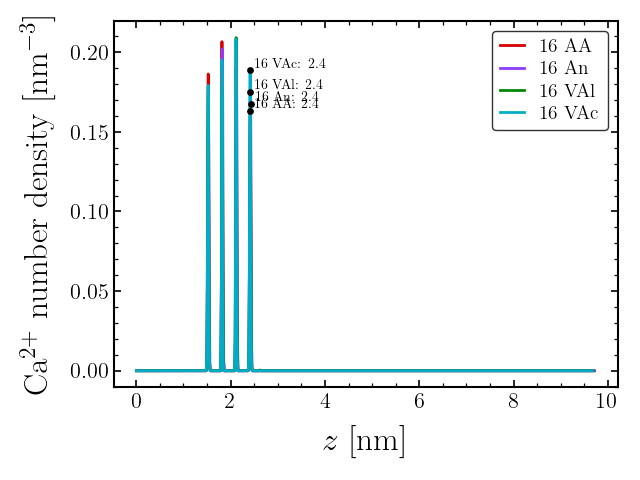

In [11]:
# find surface z-coordinate as last major peak in the number density profile
cmap = cc.glasbey
fig, ax = plt.subplots()
ax.set_xlabel(r"$z$ [nm]")
ax.set_ylabel(r"Ca$^{2+}$ number density [nm$^{-3}$]")

for i, sim in tqdm(enumerate(sims), desc="Surface position", dynamic_ncols=True, total=len(sims)):
    z_ca = sim.z_numden_ca["number_density"]
    z_pos = sim.z_numden_ca["position"]
    ax.plot(z_pos/10.0, z_ca, label=sim.label, color=cmap[i])

    maxima, _ = find_peaks(z_ca, distance=10, prominence=0.001)
    sim.z_surface_pos = np.round(z_pos[maxima[-1]], decimals=1)

    ax.scatter(sim.z_surface_pos/10, z_ca[maxima[-1]], color="black", s=15, zorder=20)
    # plot text with the z-coordinate
    ax.text(sim.z_surface_pos/10 + 0.1, z_ca[maxima[-1]], f"{sim.label}: {sim.z_surface_pos/10:.1f}", fontsize=10, ha="left", va="bottom", color="black", rotation=0, zorder=25)

    if verbose:
        print(f"Simulation: {sim.sampling} - {sim.label}")
        print(f" - Surface position [A]: {sim.z_surface_pos:.1f}")

ax.legend()

# save data
tags, z_pos = [], []
for sim in sims:
    tags.append(sim.name + "_" + sim.sampling)
    z_pos.append(sim.z_surface_pos)
df = pd.DataFrame({"tag": tags, "z_surface_pos_ang": z_pos})
df.to_csv(dir_dat / "z_surface_pos.csv", index=False)
fig.tight_layout()
fig.savefig(dir_fig / f"z_surface_pos.{fig_ext}", **fig_args)


## z Number Density Profiles

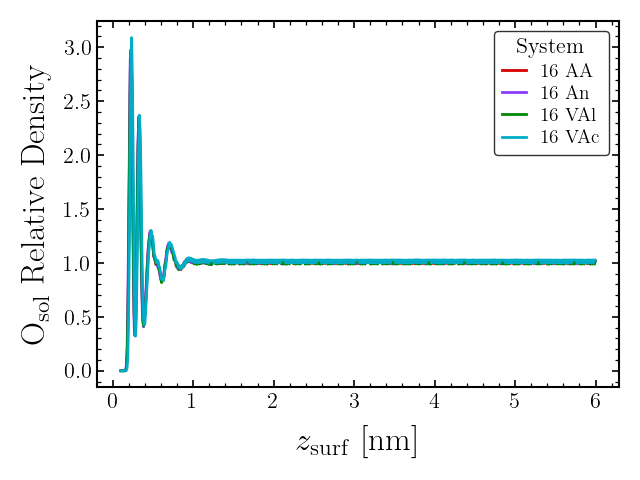

In [12]:
cmap = cc.glasbey
figname = "osol_density_z"
window = 4
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_osol["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_osol["number_density"] / np.average(
        sim.z_numden_osol["number_density"][-10:]
    )
    # moving average
    y = np.convolve(y, np.ones(window), "same") / window
    # remove data outside the range
    idx_drop = np.where((x < zmin) | (x > 6.0))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    # save data
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

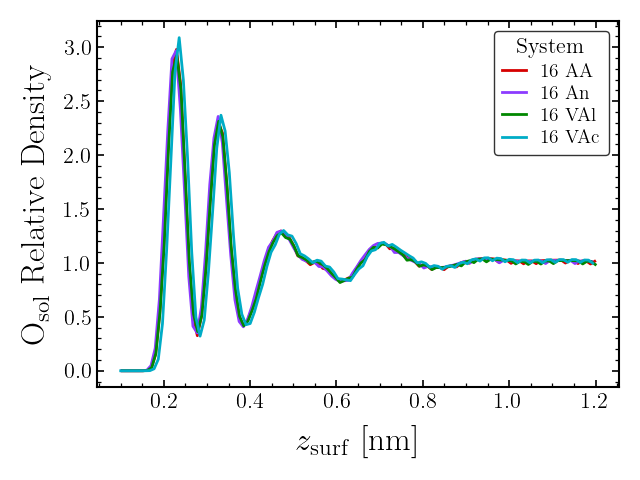

In [13]:
cmap = cc.glasbey
figname = "osol_density_z_interface"
window = 4
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_numden_osol["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_osol["number_density"] / np.average(sim.z_numden_osol["number_density"][-10:])
    # moving average
    y = np.convolve(y, np.ones(window), "same") / window
    # remove data outside the range
    idx_drop = np.where((x < zmin) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    # save data
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


Number of data points: 1000
Number of data points: 1000
Number of data points: 1000
Number of data points: 1000


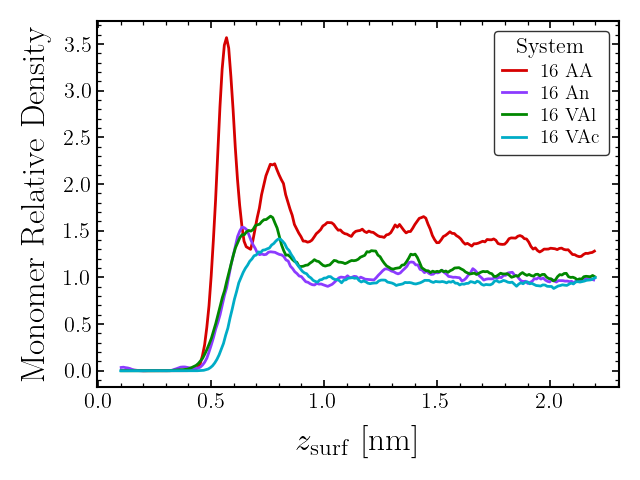

In [14]:
cmap = cc.glasbey
figname = "pe_density_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Monomer Relative Density")
window = 5

data = {}
for i, sim in enumerate(sims):
    if sim.z_numden_pe is None:
        continue

    print(f"Number of data points: {len(sim.z_numden_pe['position'])}")
    x = (sim.z_numden_pe["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_pe["number_density"] / np.average(
        sim.z_numden_pe["number_density"][-200:-120]
    )
    y = np.convolve(y, np.ones(window), "same") / window
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)

    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

if len(data) > 0:
    ax.legend(title="System")
    save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
    plt.show()
else:
    fig.clf()
    print(f"No data found")


Number of data points: 1000
Number of data points: 1000
Number of data points: 1000
Number of data points: 1000


/tmp/ipykernel_1096003/255177117.py:25: RuntimeWarning: divide by zero encountered in log
  y = -np.log(y)


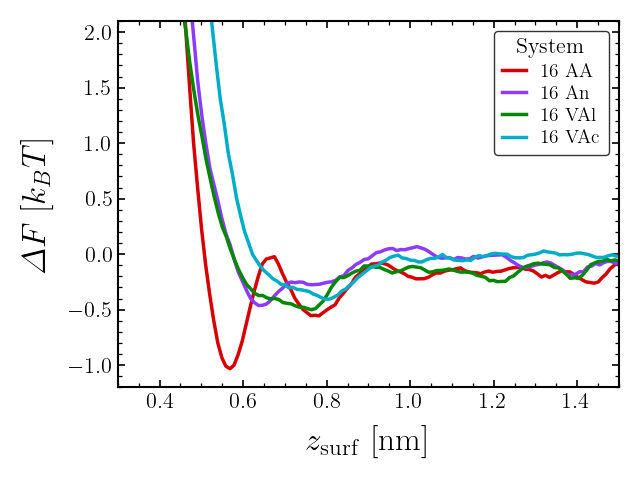

In [15]:
cmap = cc.glasbey
figname = "pe_density_z_fes"
fig, ax = plt.subplots()
window = 5

ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_xlim(0.3, 1.5)
ax.set_ylabel(r"$\Delta F$ [$k_BT$]")
ax.set_ylim(-1.2, 2.1)

data = {}
for i, sim in enumerate(sims):
    if sim.z_numden_pe is None:
        continue

    print(f"Number of data points: {len(sim.z_numden_pe['position'])}")
    x = (sim.z_numden_pe["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_pe["number_density"] / np.average(
        sim.z_numden_pe["number_density"][-200:-120]
    )
    y = np.convolve(y, np.ones(window), "same") / window
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    y = -np.log(y)
    y = y - np.average(y[-20:])

    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)], linewidth=2.5)

if len(data) > 0:
    ax.legend(title="System")
    save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
    plt.show()
else:
    fig.clf()
    print(f"No data found")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


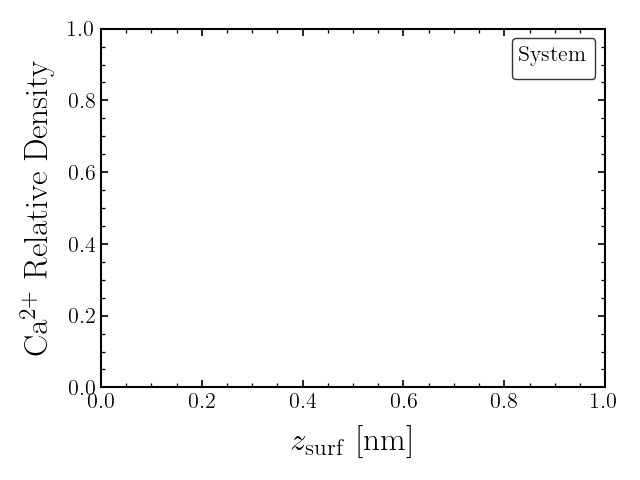

In [16]:
cmap = cc.glasbey
figname = "ca_density_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Ca$^{2+}$ Relative Density")
window = 4

data = {}
for i, sim in enumerate(sims):
    if "Ca" not in sim.label:
        continue

    x = (sim.z_numden_ca["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_ca["number_density"] / np.average(
        sim.z_numden_ca["number_density"][-200:-120]
    )
    y = np.convolve(y, np.ones(window), "same") / window
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System")

if len(data) > 0:
    save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
    plt.show()


## z Charge Density Profiles

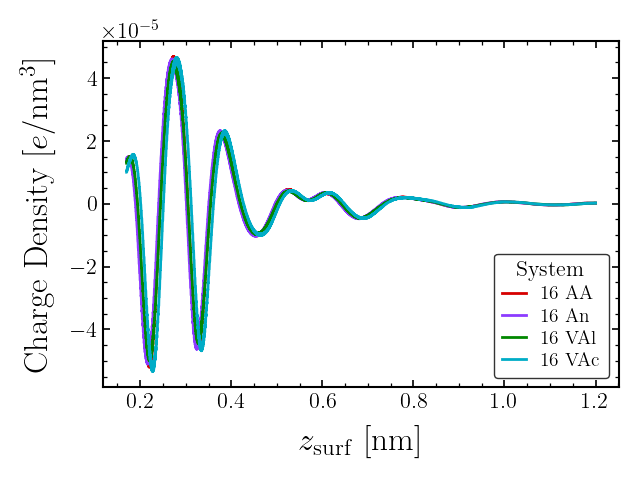

In [17]:
cmap = cc.glasbey
figname = "all_chargedensity_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")
window = 100

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_all["charge_density"] / (10**3) 
    y = np.convolve(y, np.ones(window), "same") / window
    
    idx_drop = np.where((x < 0.17) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System", loc="lower right")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


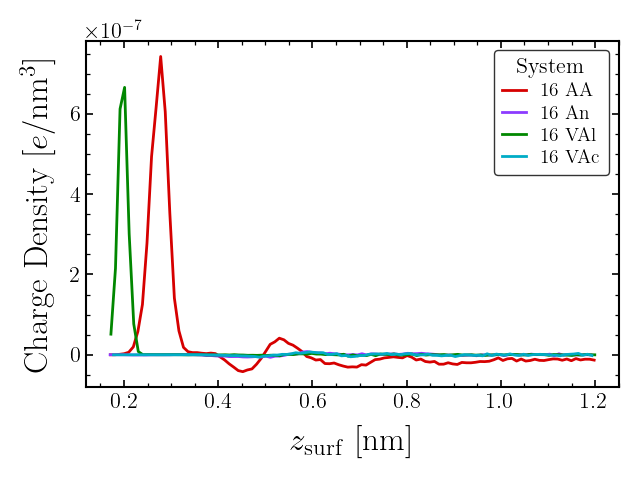

In [18]:
cmap = cc.glasbey
figname = "notsol_chargedensity_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_not_sol["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_not_sol["charge_density"] / (10**3)
    idx_drop = np.where((x < 0.17) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y
    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


## z Electrostatic Potential Profiles

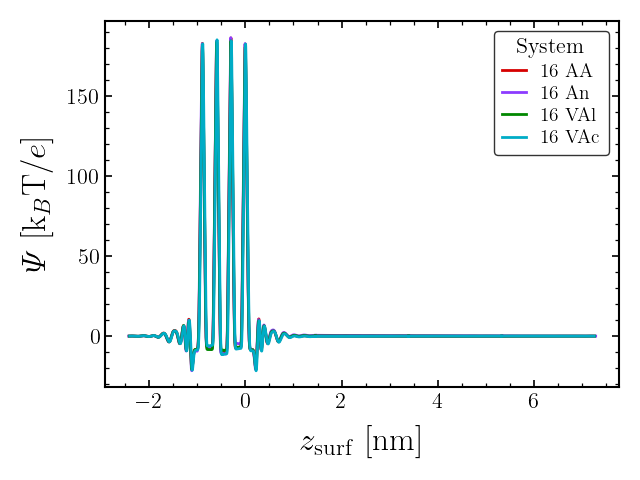

In [19]:
cmap = cc.glasbey
figname = "potential_nondim_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"$\Psi$ [k$_B$T/$e$]")
window = 1

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_all["potential"] / kte_dimension
    y = np.convolve(y, np.ones(window), "same") / window
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System", loc="upper right")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


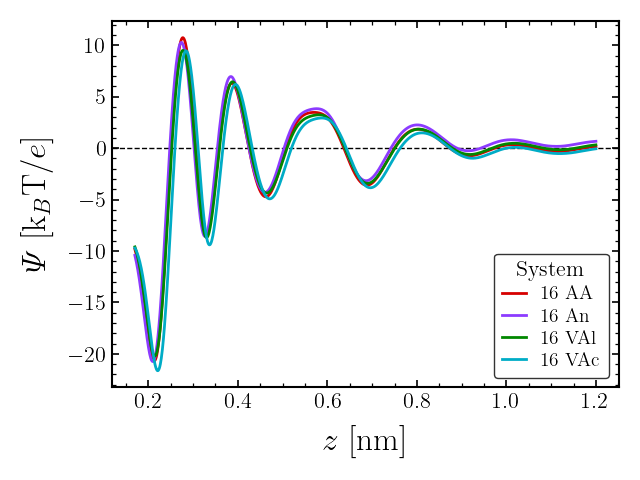

In [20]:
cmap = cc.glasbey
figname = "potential_nondim_z_interface"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z$ [nm]")
ax.set_ylabel(r"$\Psi$ [k$_B$T/$e$]")
window = 1

ax.axhline(0, color="black", linestyle="--", linewidth=1.0)

data = {}
for i, sim in enumerate(sims):
    x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_all["potential"] / kte_dimension
    y = np.convolve(y, np.ones(window), "same") / window
    idx_drop = np.where((x < 0.17) | (x > zmax))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System", loc="lower right")

save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


## z Angular Distribution Heatmaps

/nfs/zeal_mount/aglisman/anaconda3/envs/analysis-surface/lib/python3.11/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


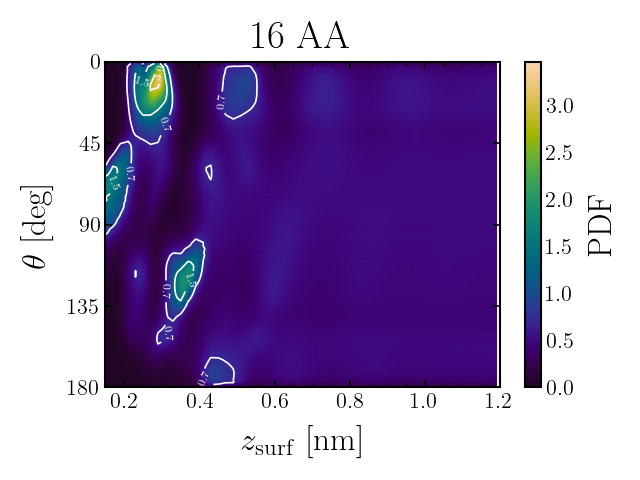

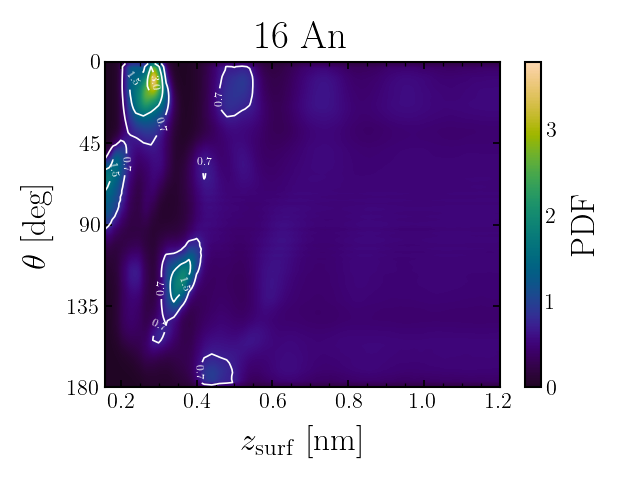

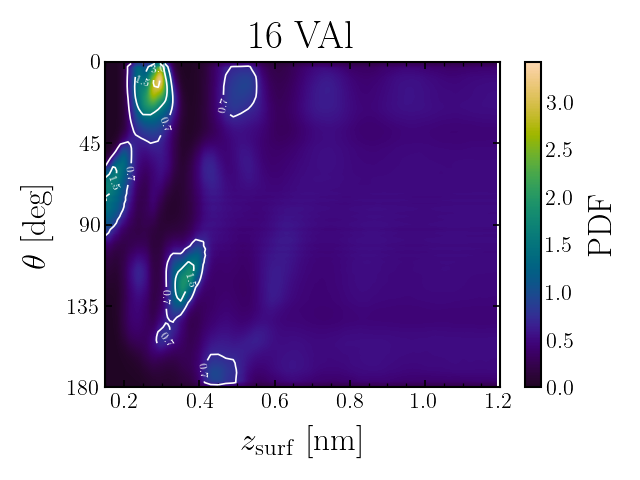

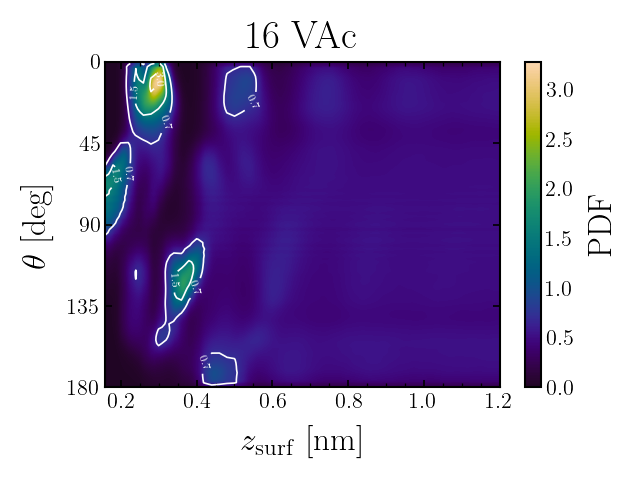

In [21]:
cmap = cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9)
window = 3

for idx, sim in enumerate(sims):

    # get the z-coordinate of the solvent orientation data
    z = np.average([sim.z_sol_orient_zmin, sim.z_sol_orient_zmax], axis=0)
    z_coord = (z - sim.z_surface_pos) / 10.0
    idx_in_range = np.where((z_coord >= zmin) & (z_coord <= zmax))
    z_coord = z_coord[idx_in_range]
    theta_coord = np.degrees(sim.z_sol_orient[0]["bin_centers"])

    # make meshgrid
    XX, YY = np.meshgrid(z_coord, theta_coord)
    Z = np.zeros_like(XX)
    for i, line in enumerate(sim.z_sol_orient):
        # if index not in range, skip
        if i not in idx_in_range[0]:
            continue
        Z[:, i] = np.convolve(line["angle_density"], np.ones(window), "same") / window
    data = {"XX": XX.ravel(), "YY": YY.ravel(), "Z": Z.ravel()}
    
    figname = f"angular_distribution_{sim.name}"
    fig, ax = plt.subplots()
    
    # plot the data
    im = ax.imshow(
        Z, 
        cmap=cmap,
        aspect="auto",
        origin="upper",
        extent=[XX.min(), XX.max(), YY.min(), YY.max()],
        interpolation="gaussian",
    )
    fig.colorbar(im, ax=ax, label="PDF")
    # add contour lines
    levels = np.array([0.7, 1.5, 3.0])
    ax.clabel(
        ax.contour(XX, YY, Z, levels=levels, colors="white", linewidths=1.2, linestyles="solid"),
        fmt="%.1f",
        inline=True,
        fontsize=8,
    )

    ax.set_ylabel(r"$\theta$ [deg]")
    ax.set_yticks([180, 135, 90, 45, 0])
    ax.set_ylim(180, 0)
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    ax.set_title(sim.label)

    fig.tight_layout()
    save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)

